## This Notebook gives an example on how to plot the quality control plots for MERFISH cell clustering (Figure 1 in the manuscript)

In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import zscore
import numpy as np
from scipy.stats import ttest_1samp
import seaborn as sns
from adjustText import adjust_text
from scipy.stats import pearsonr

In [2]:
#### PLOT GENE
# Function to plot gene expression across single cells in X_spatial

def plot_gene_scdata(scdata2,gene='SOX9',nmax=20,sz_min=5,sz_max=30,transpose=1,flipx=1,flipy=1,tag='X_spatial'):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(15, 15), facecolor="white")
    Xcells = scdata2.obsm[tag][:,::transpose]*[flipx,flipy]
    ign = list(scdata2.var.index).index(gene)
    if 'X_raw' not in scdata2.obsm:
        Xnorm = (np.exp(scdata2.X)-1)
        ncts = np.sum(Xnorm,axis=1)[0]
        scdata2.obsm['X_raw']=np.round(Xnorm/ncts*np.array(scdata2.obs['total_counts'])[:,np.newaxis])
    cts = scdata2.obsm['X_raw'][:,ign].copy()
    plt.style.use("default")
    cts[np.isnan(cts)]=0
    #cts[cts>20]=0
    ncts = np.clip(cts/nmax,0,1)
    size = sz_min+ncts*(sz_max-sz_min)
    from matplotlib import cm as cmap
    cols = cmap.coolwarm(ncts)

    good_cells = slice(None)
    good_cells = np.argsort(cts)

    XC = -Xcells[good_cells,::-1]
    fig = plt.figure(facecolor='k')
    plt.title(gene+' - N max '+str(nmax))
    fig.set_facecolor('white')
    plt.scatter(XC[:,0],XC[:,1],c=cols[good_cells],s=size[good_cells])
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.axis("equal")

    return fig

In [3]:
###PLOT CLUSTER NAME
# Function to plot cell-types across single cells in X_spatial

def plot_cluster_name_scdata(scdata,cmap,clusters=['Neuron','Astro'],transpose=1,flipx=1,flipy=1,sbig=30,small=5):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(40, 40), facecolor="white")

    from matplotlib import pylab as plt
    x,y = (scdata.obsm['X_spatial']*[-flipx,-flipy])[:,::-transpose].T
    
    plt.scatter(x, y, c='gray', s=small, marker='.')
    i=0
    for cluster in clusters:
        cluster_ = str(cluster)
        inds = scdata.obs["cluster_names"] == cluster_
        x_ = x[inds]
        y_ = y[inds]
        col = cmap[int(i) % len(cmap)]
        i=i+1
        plt.scatter(x_, y_, c=col, s=sbig, marker='.',label = cluster_)
    
    plt.grid(False)
    plt.axis("off")
    plt.axis("equal")
    plt.legend()
    plt.tight_layout()
    return fig

In [4]:
C4 = sc.read_h5ad('../C4_ref.h5ad')

In [5]:
#######################################
#### FIGURE 1D: UMAP
#######################################

/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cma

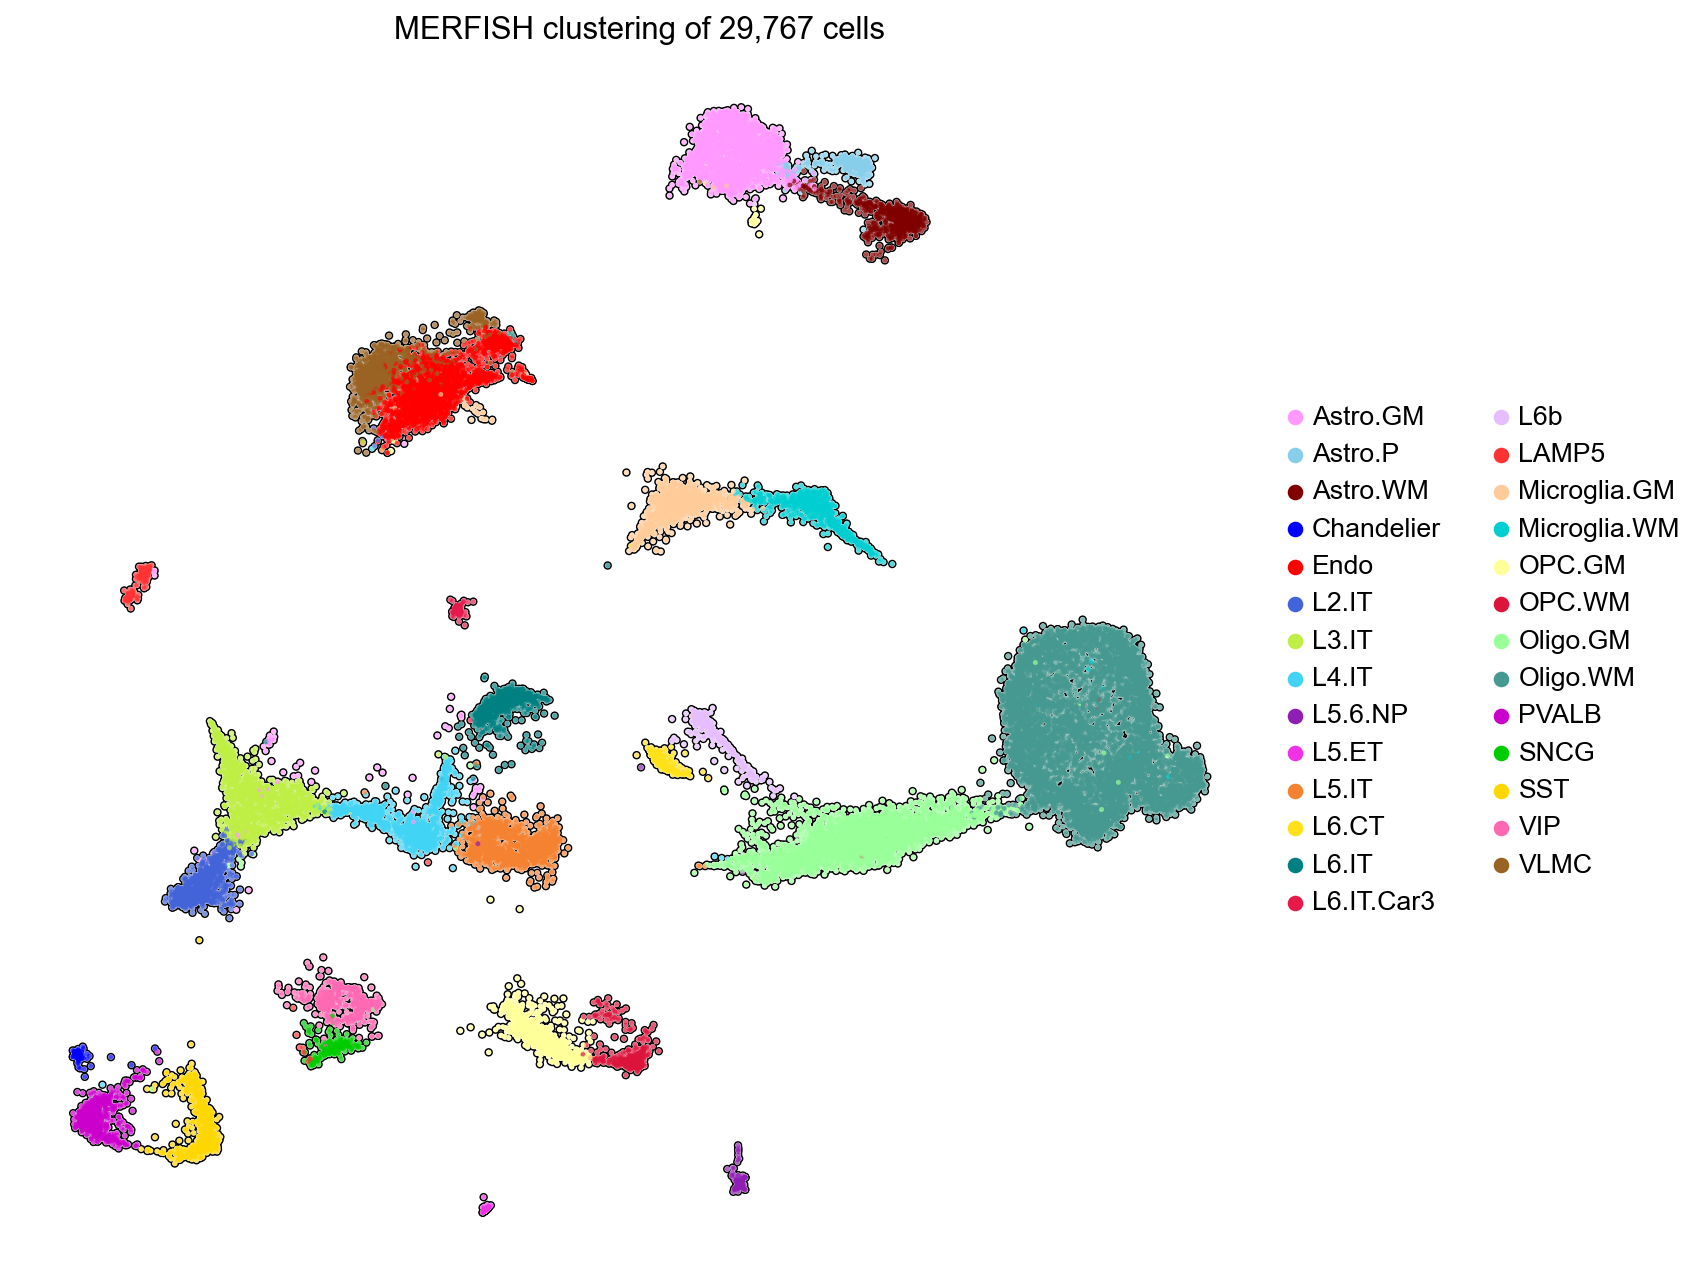

In [6]:
    cmap = [
        '#ff99ff', '#87CEEB', '#800000', #Astro GM, P, WM
        '#0000ff', #Chandelier
        '#FF0000', #Endo
        '#4363d8', '#bfef45', #L2, L3, 
        '#42d4f4',  # L4
        '#911eb4', '#f032e6','#f58231', #L56NP, L5ET, L5
        '#ffe119',  '#008080', '#e6194B', '#e6beff', #L6CT, L6, L6Car3, L6b
        '#ff3333', #LAMP5
        '#ffcc99',  '#00CED1',  '#ffff99','#DC143C', #Microglia GM, WM, OPC GM, WM
        '#99ff99', '#469990',  #Oligo GM, WM
        '#cc00cc', #PVALB
        '#00cc00','#FFD700',   '#FF69B4', #SNCG, SST, VIP
        '#9A6324', #VLMC     
    ]

plt.style.use('default')
sc.set_figure_params(figsize=(10,10))
fig = sc.pl.umap(
    C4,
    color="cluster_names",
    add_outline=True,
    #legend_loc="on data",
    size=20,
    legend_fontsize=12,
    legend_fontoutline=1,
    frameon=False,
    title=f"MERFISH clustering of {len(C4):,d} cells",
    palette=cmap,return_fig=True
)

In [7]:
#######################################
#### FIGURE 1E: Heatmap Cell-type correlation MERFISH vs ABA MTG
#######################################

In [8]:
merged_dt=pd.read_csv('../../AllenBrainAtlas/MTG_filtered.csv')
merged_dt

,gene_symbol,Lamp5,Pax6,Sncg,Vip,Sst.Chodl,Sst,Pvalb,Chandelier,L2.3.IT,...,L6.CT,L6b,L6.IT.Car3,L5.6.NP,Astro,OPC,Oligo,Endo,VLMC,Micro.PVM
0,PIK3CD,0.077312,0.000000,0.000000,0.018526,3.144687,1.121397,0.321770,0.000000,0.052362,...,0.000000,0.342513,0.000000,1.032886,0.000000,0.000000,0.000000,0.000000,0.516398,1.599939
1,WNT4,0.000000,0.300711,0.098131,0.116332,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.087777,0.000000
2,LDLRAP1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.531197,0.000000,0.000000
3,MED8,0.000000,0.000000,0.000000,0.000000,0.061347,0.000000,0.000000,0.000000,1.665511,...,0.626515,0.483278,0.082215,0.207659,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,PDE4B,3.458250,9.700257,8.113090,9.547094,9.769103,8.007303,4.063421,0.092688,7.839797,...,9.789872,9.233068,2.262211,8.706653,9.732892,10.786498,11.905638,1.277929,2.391891,5.779385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,PVALB,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.777930,6.112058,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
271,PCDH11X,0.228795,7.145058,1.828613,7.553617,0.000000,8.236500,4.251611,0.000000,4.552720,...,6.836499,9.993534,5.444011,3.021610,0.000000,5.959079,0.160883,0.000000,0.000000,0.000000
272,PLP1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.021028,0.000000,0.000000,0.000000,0.000000,4.774480,12.175081,0.000000,0.000000,0.000000
273,IL1RAPL2,5.475849,8.924381,8.622897,2.262932,10.989513,0.000000,0.704482,4.501947,0.539772,...,0.000000,0.000000,0.913277,1.528573,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


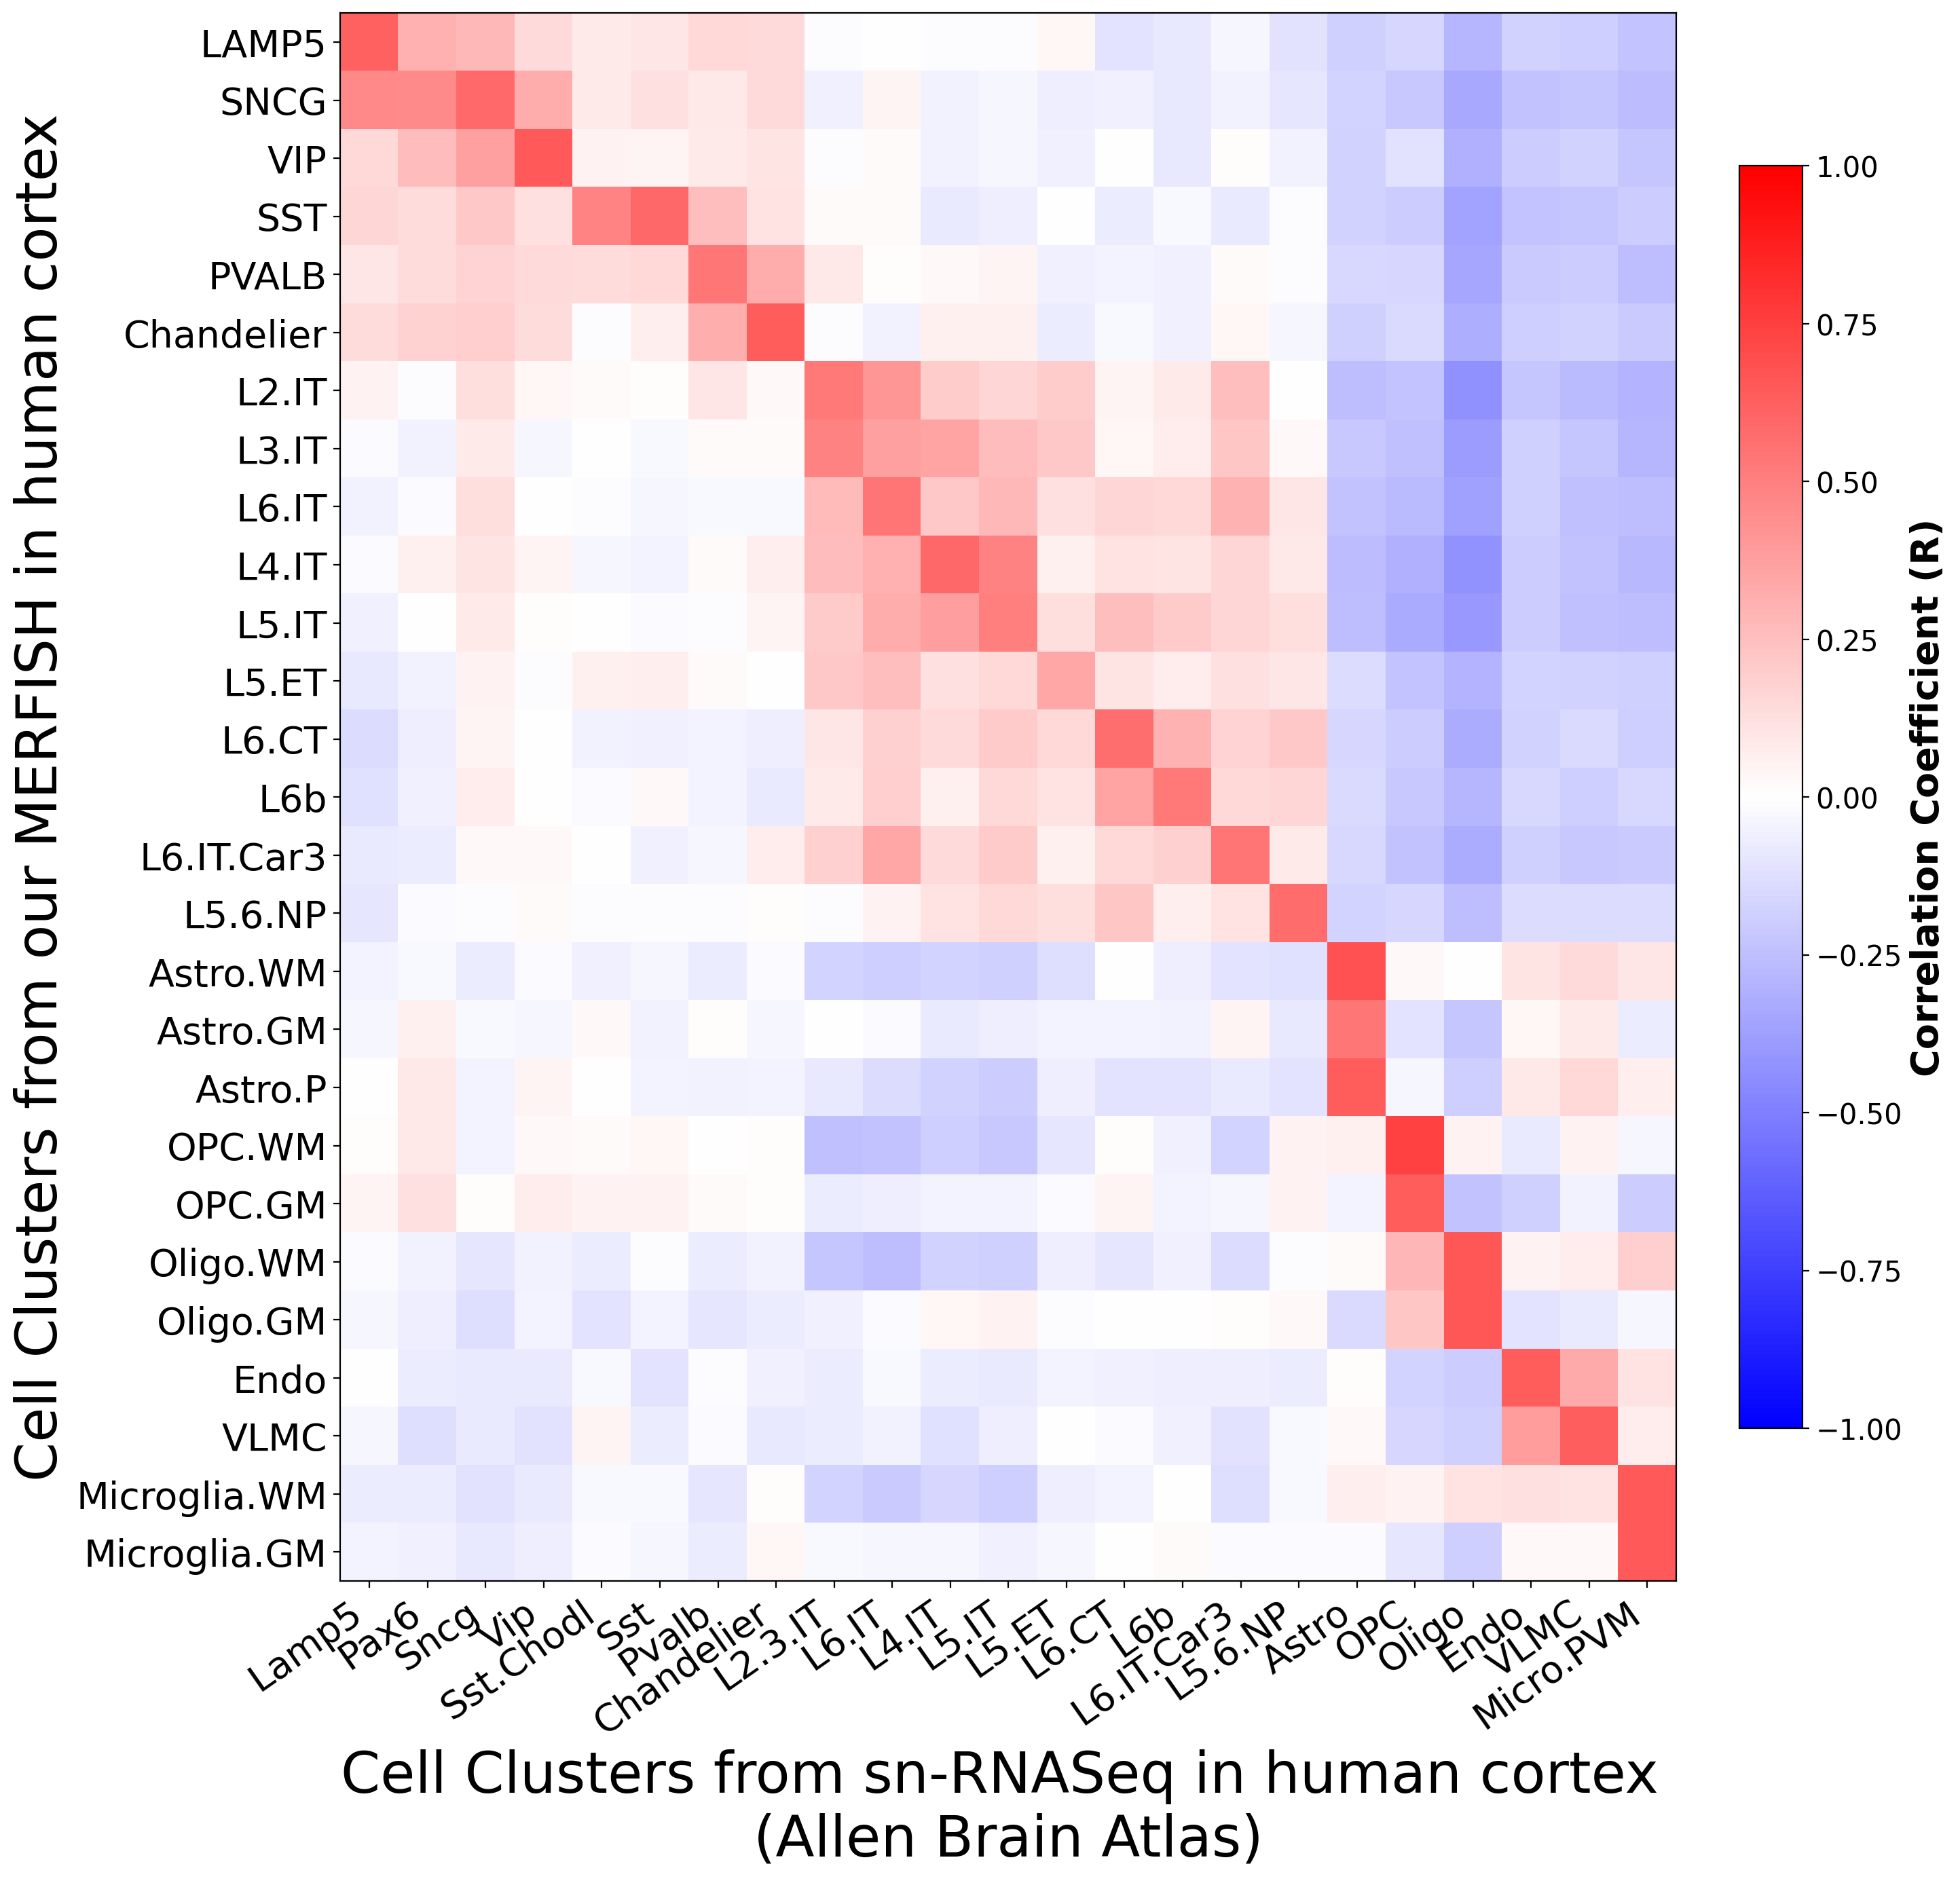

In [9]:
cluster_order = ["LAMP5", "SNCG",'VIP', "SST", "PVALB","Chandelier", "L2.IT", "L3.IT",'L6.IT', "L4.IT",'L5.IT', 'L5.ET', "L6.CT",'L6b','L6.IT.Car3', "L5.6.NP","Astro.WM", 'Astro.GM','Astro.P', 'OPC.WM','OPC.GM',  'Oligo.WM', 'Oligo.GM','Endo', 'VLMC','Microglia.WM','Microglia.GM']
C4_s = C4[:,merged_dt["gene_symbol"]]

X_MERFISH_zscored = zscore(C4_s.X,axis=0)
clusters = C4_s.obs['cluster_names']
X_MERFISH_zscored_per_cluster = np.array([np.mean(X_MERFISH_zscored[cl==clusters],axis=0) for cl in cluster_order])

X_seq = np.array(merged_dt.iloc[:,1:]).T
X_seq[np.isnan(X_seq)]=0
X_seq_zscored = zscore(X_seq,axis=0)
X_seq_zscored[np.isnan(X_seq_zscored)]=0

Mcor = [[np.corrcoef(clMER,clSEQ)[0,1] for clSEQ in X_seq_zscored] for clMER in X_MERFISH_zscored_per_cluster]
names_seq = list(merged_dt.keys())[1:]
dic_rename = dict(zip(C4_s.obs['leiden'],C4_s.obs['cluster_names']))

plt.style.use('default')
plt.figure(figsize=(30,15))
im = plt.imshow(Mcor,cmap='bwr', vmin=-1, vmax=1)
cbar = plt.colorbar(im, fraction=0.02, pad=0.02)
cbar.set_label('Correlation Coefficient (R)', fontsize=20, fontweight='bold')
cbar.ax.tick_params(labelsize=15)
plt.xticks(np.arange(len(names_seq)),names_seq,rotation=35,ha='right',size=20);
plt.yticks(np.arange(len(cluster_order)),cluster_order,size=20)
plt.ylabel('Cell Clusters from our MERFISH in human cortex', size=30)
plt.xlabel('Cell Clusters from sn-RNASeq in human cortex \n(Allen Brain Atlas)', size=30);

In [10]:
Mcor = np.array(Mcor)

max_r = Mcor.max(axis=1)
max_idx = Mcor.argmax(axis=1)
max_allen_clusters = [names_seq[i] for i in max_idx]

results_df = pd.DataFrame({
    'MERFISH_cluster': cluster_order,
    'Max_correlation': max_r,
    'Best_matching_Allen_cluster': max_allen_clusters
})

mean_corr = np.mean(max_r)
std_corr = np.std(max_r)

t_stat, p_val = ttest_1samp(max_r.flatten(), 0)

print("===== Summary =====")
print(f"Mean correlation (all pairs): {mean_corr:.3f} ± {std_corr:.3f}")
print(f"T-test p-value (r > 0): {p_val:.5f}")
print()
print("===== Per-MERFISH Cluster Max Correlation =====")
print(results_df)


===== Summary =====
Mean correlation (all pairs): 0.589 ± 0.077
T-test p-value (r > 0): 0.00000

===== Per-MERFISH Cluster Max Correlation =====
   MERFISH_cluster  Max_correlation Best_matching_Allen_cluster
0            LAMP5         0.624990                       Lamp5
1             SNCG         0.582293                        Sncg
2              VIP         0.644174                         Vip
3              SST         0.593692                         Sst
4            PVALB         0.532252                       Pvalb
5       Chandelier         0.634577                  Chandelier
6            L2.IT         0.520574                     L2.3.IT
7            L3.IT         0.490213                     L2.3.IT
8            L6.IT         0.545990                       L6.IT
9            L4.IT         0.588152                       L4.IT
10           L5.IT         0.502985                       L5.IT
11           L5.ET         0.344548                       L5.ET
12           L6.CT     

In [11]:
#######################################
#### FIGURE 1D: HTT expression Correlation MERFISH vs ABA PFC
#######################################

In [12]:
counts = sc.read_h5ad('../../SEAAD_PFC/SEAAD_A9_RNAseq_final-nuclei.2024-02-13.h5ad')

In [13]:
counts.obs['Neurotypical reference'] = counts.obs['Neurotypical reference'].astype(str).map({'True': True, 'False': False})

In [14]:
counts.obs['Neurotypical reference'].unique()

array([False,  True])

In [15]:
ABA_CTL=counts[counts.obs['Neurotypical reference']==True].copy()

In [16]:
M_adata=sc.read_h5ad('../adata_0803_0908_f_AGG_orig.h5ad')

In [17]:
M_CTL=M_adata[M_adata.obs['HD']==False].copy()

In [18]:
# Match cluster names
cluster_map = {
    'L2.IT': 'L2/3 IT',
    'L3.IT': 'L2/3 IT',
    'L4.IT': 'L4 IT',
    'L5.IT': 'L5 IT',
    'L5.ET': 'L5 ET',
    'L5.6.NP': 'L5/6 NP',
    'L6.IT': 'L6 IT',
    'L6.Car3': 'L6 IT Car3',
    'L6.CT': 'L6 CT',
    'L6b': 'L6b',
    'SST': 'Sst',
    'PVALB': 'Pvalb',
    'VIP': 'Vip',
    'LAMP5': 'Lamp5',
    'Chandelier': 'Chandelier',
    'SNCG': 'Sncg',
    'Astro.P': 'Astrocyte', 
    'Astro.WM': 'Astrocyte', 
    'Astro.GM': 'Astrocyte',
    'Oligo.WM': 'Oligodendrocyte',
    'Oligo.GM': 'Oligodendrocyte',
    'OPC': 'OPC',
    'Endo': 'Endothelial',
    'VLMC': 'VLMC',
    'Microglia': 'Microglia-PVM',
}

In [19]:
# Remap cluster names for M_CTL
M_CTL.obs['mapped_cluster'] = M_CTL.obs['cluster_names'].map(cluster_map).fillna(M_CTL.obs['cluster_names'])

In [20]:
# Normalize expression to max for each dataset
m_means = (
    pd.DataFrame({
        'cluster': M_CTL.obs['mapped_cluster'],
        'expr': M_CTL[:, 'HTT'].X.toarray().flatten()
                if not isinstance(M_CTL.X, np.ndarray)
                else M_CTL[:, 'HTT'].X.flatten()
    })
    .groupby('cluster')['expr'].mean()
)

m_means_norm = m_means / m_means.max()

aba_means = (
    pd.DataFrame({
        'cluster': ABA_CTL.obs['Subclass'],
        'expr': ABA_CTL[:, 'HTT'].X.toarray().flatten()
                if not isinstance(ABA_CTL.X, np.ndarray)
                else ABA_CTL[:, 'HTT'].X.flatten()
    })
    .groupby('cluster')['expr'].mean()
)

aba_means_norm = aba_means / aba_means.max()

/var/folders/7p/t1dymgvj689ffh7fbygsmbzc0000gp/T/ipykernel_50689/1051973791.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pd.DataFrame({


In [21]:
common_clusters = m_means_norm.index.intersection(aba_means_norm.index)

m_vals_norm = m_means_norm.loc[common_clusters]
aba_vals_norm = aba_means_norm.loc[common_clusters]

rho, pval = pearsonr(m_vals_norm, aba_vals_norm)
print(f"Pearson correlation for HTT across clusters: {rho:.2f} (p={pval:.3e})")

Pearson correlation for HTT across clusters: 0.89 (p=4.536e-08)


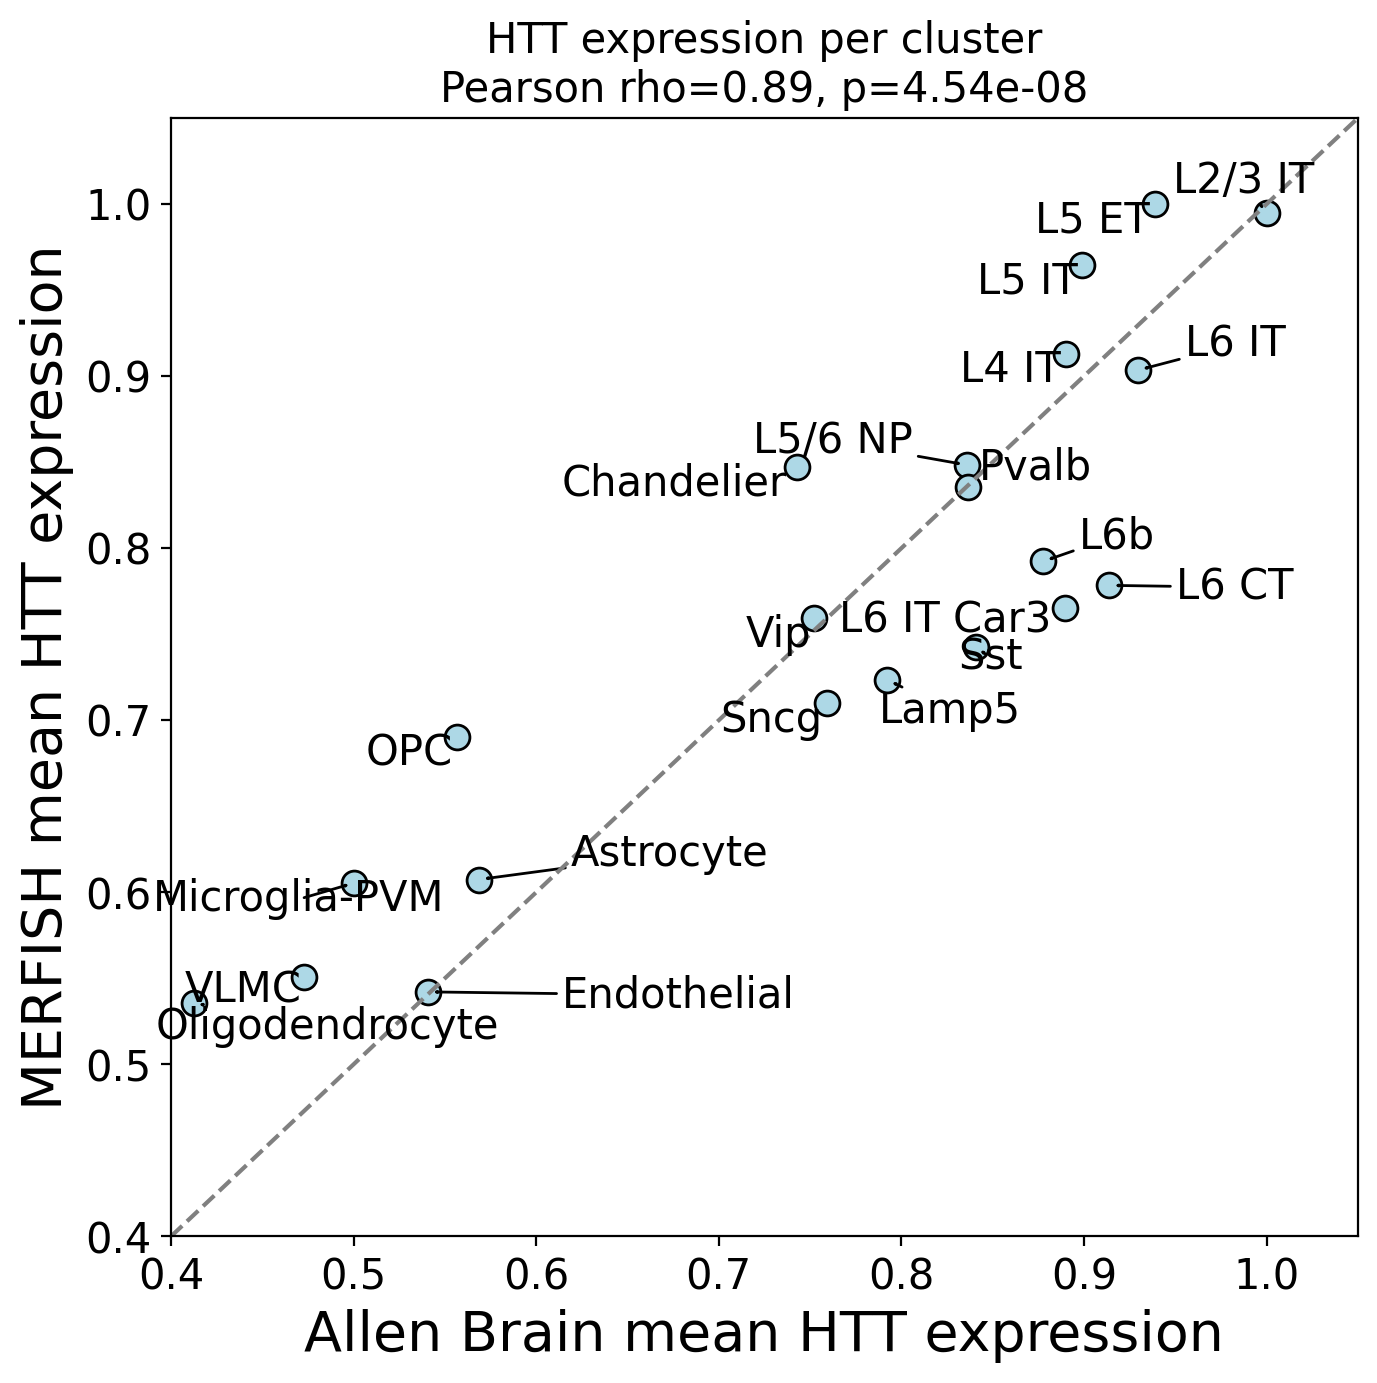

In [22]:
plt.figure(figsize=(7,7))
plt.scatter(aba_vals_norm, m_vals_norm, c='lightblue', s=80, edgecolor='black')
texts = []
for c in common_clusters:
    texts.append(plt.text( aba_vals_norm[c], m_vals_norm[c], c, fontsize=15))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black'))

plt.ylabel('MERFISH mean HTT expression', size=20)
plt.xlabel('Allen Brain mean HTT expression', size=20)
plt.yticks(size=15)
plt.xticks(size=15)
plt.title(f'HTT expression per cluster\nPearson rho={rho:.2f}, p={pval:.2e}', size=15)
plt.axline((0,0), slope=1, color='gray', linestyle='--')
plt.xlim(0.4,1.05)
plt.ylim(0.4,1.05)
plt.tight_layout()
plt.show()